### Carga de librerias


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats as st
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

from sklearn.tree import DecisionTreeClassifier

### Carga de archivos

In [3]:
hipotesis = pd.read_csv ('hypotheses_us.csv', sep =(';'))
orders = pd.read_csv ('orders_us.csv')
visits = pd.read_csv ('visits_us.csv')

### Limpieza de datos

- Archivo de hipotesis tranformamos los datos a tipo snakecase

In [4]:
hipotesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [5]:
hipotesis.columns = [x.lower().replace(' ', '') for x in hipotesis.columns]
hipotesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


## Visualizamos los datos de orders

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


Transformamos los datos de la columna date a tipo correcto 

In [7]:
orders['date'] = pd.to_datetime(orders['date'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


Tranformamos los nombres de las columnas a snakecase


In [8]:
orders.columns = [x.lower().replace (' ','') for x in orders.columns]
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


Revisamos, si existen duplicados

In [9]:
orders[orders.duplicated()]

,transactionid,visitorid,date,revenue,group


## Analizamos los datos del archivo visits

In [10]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Transformamos los datos de la columna date a tipo correcto 

In [11]:
visits['date'] = pd.to_datetime(visits['date'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Revisamos si existen duplicados


In [12]:
visits[visits.duplicated()]

,date,group,visits


### Parte 1. Priorizar hipótesis

Aplicamo el framework ICE

In [13]:
hipotesis ['ICE'] = (hipotesis['impact'] * hipotesis['confidence']) / hipotesis['effort']

print (hipotesis[['hypothesis', 'ICE']].sort_values (by='ICE', ascending=False))

hipotesis

                                          hypothesis        ICE
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000


,hypothesis,reach,impact,confidence,effort,ICE
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000
3,Change the category structure. This will incre...,8,3,3,8,1.125000
4,Change the background color on the main page. ...,3,1,1,1,1.000000
5,Add a customer review page. This will increase...,3,2,2,3,1.333333
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000


Aplicamos el framework RICE

In [14]:
hipotesis ['RICE'] = (hipotesis['reach'] * hipotesis ['impact'] * hipotesis ['confidence']) / hipotesis['effort']
print (hipotesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False))

hipotesis

                                          hypothesis   RICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts ...   16.2
3  Change the category structure. This will incre...    9.0
1  Launch your own delivery service. This will sh...    4.0
5  Add a customer review page. This will increase...    4.0
4  Change the background color on the main page. ...    3.0


,hypothesis,reach,impact,confidence,effort,ICE,RICE
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2


- Vemos que con RICE se prioriza la hipotesis 7, esto se deriba al alcance que tiene que es de 10 mientras que en ICE es el numero 8 por que el alcance es de 1, sin embargo en impacto, confianza y ezfuerzo son mas altos.

- Lo vemos tambien en ICE es la segunda hipotesis (hiposiste 0) esto se deriba a que a los valores de impacto, confianza y esfuerzo, mientras que es RIce baja por el alcance que es de 3

### Parte 2. Análisis del test A/B

- Ingreso acumulado por grupo


<function matplotlib.pyplot.show(close=None, block=None)>

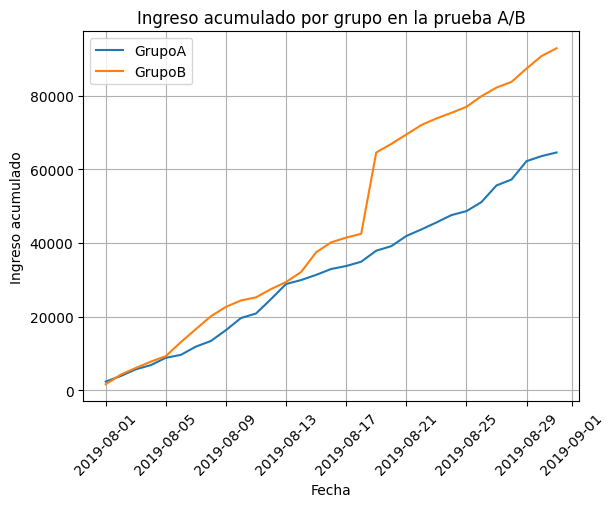

In [15]:
# Calculamos el ingreso acumulado por grupo
cumulative_revenue = orders.groupby(['date','group'])['revenue'].sum().groupby('group').cumsum().reset_index()

#Graficamos el ingreso acumulado por grupo
plt.Figure (figsize=(12,6))
for group in cumulative_revenue['group'].unique():
    subset = cumulative_revenue[cumulative_revenue['group']== group]
    plt.plot(subset['date'],subset['revenue'], label=f'Grupo{group}')

plt.xlabel ('Fecha')
plt.ylabel ('Ingreso acumulado')
plt.title ('Ingreso acumulado por grupo en la prueba A/B')
plt.legend ()
plt.grid (True)
plt.xticks(rotation=45)
plt.show

- Vemos que la prueba B muestra un crecimiento mas pronunciado lo que indica que genero mas ingresos a lo largo del experimento, sin embargo hay un salto brusco lo que podría indicar que hubo una compra inusualmente grande en un día en especifico 

### Tamaño de pedido promedio acumulado por grupo

<function matplotlib.pyplot.show(close=None, block=None)>

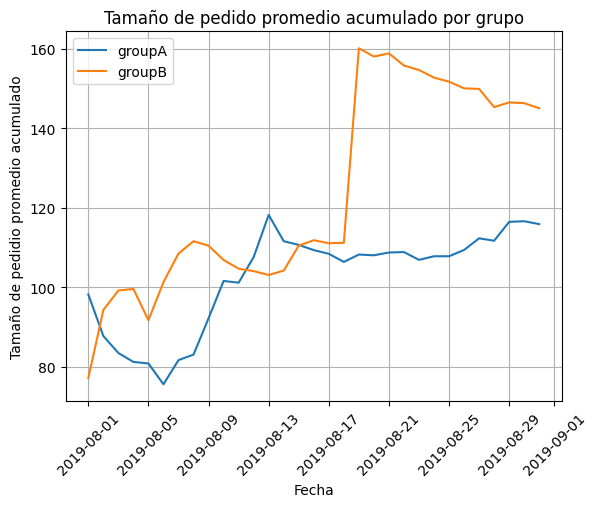

In [16]:
#Calculamos el numero acumulado de pedidos por grupo
cumulative_orders = orders.groupby(['date','group']).size().groupby('group').cumsum().reset_index(name='num_orders')

#Unimos con el ingreso acumulado
cumulative_avg_order = cumulative_revenue.merge(cumulative_orders, on=['date','group'])
cumulative_avg_order['avg_order_value'] = cumulative_avg_order['revenue'] / cumulative_avg_order['num_orders']

#Graficamos el tamaño de pedido promedio acumulado por grupo
plt.Figure(figsize=(12,6))
for group in cumulative_avg_order['group'].unique():
    subset = cumulative_avg_order[cumulative_avg_order['group']== group]
    plt.plot(subset['date'], subset['avg_order_value'], label= f'group{group}')

plt.xlabel ('Fecha')
plt.ylabel ('Tamaño de pedidio promedio acumulado')
plt.title ('Tamaño de pedido promedio acumulado por grupo')
plt.legend()
plt.grid (True)
plt.xticks(rotation=45)
plt.show





- Vemos que la prueba B muestra un crecimiento mas pronunciado lo que indica que genero mas ingresos a lo largo del experimento, sin embargo hay un salto brusco lo que podría indicar que hubo una compra inusualmente grande en un día en especifico. Si al final del experimento los grupos convergen, podría indicar que no hay una diferencia significativa. Si persisten diferencias, entonces un grupo tiene una ventaja en el tamaño promedio de pedido.

### Diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A

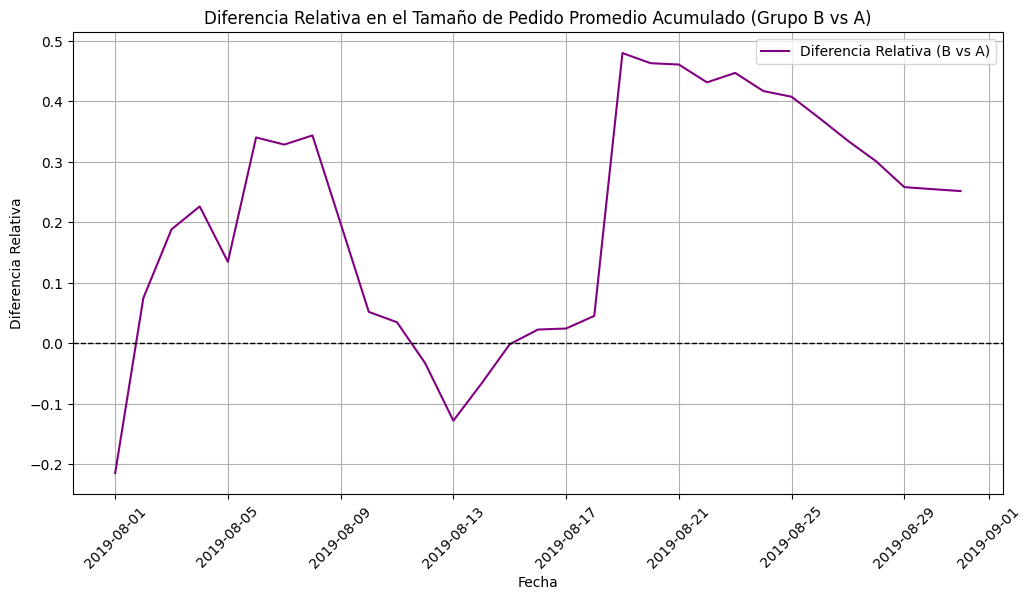

In [17]:
# Organizamos los datos para comparar los grupos A y B
cumulative_pivot = cumulative_avg_order.pivot(index="date", columns="group", values="avg_order_value")

# Calcular la diferencia relativa (Grupo B en comparación con Grupo A)
cumulative_pivot["relative_difference"] = (cumulative_pivot["B"] / cumulative_pivot["A"]) - 1

# Graficar la diferencia relativa en el tamaño de pedido promedio acumulado
plt.figure(figsize=(12, 6))
plt.plot(cumulative_pivot.index, cumulative_pivot["relative_difference"], label="Diferencia Relativa (B vs A)", color='purple')

plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Línea base en 0
plt.xlabel("Fecha")
plt.ylabel("Diferencia Relativa")
plt.title("Diferencia Relativa en el Tamaño de Pedido Promedio Acumulado (Grupo B vs A)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

- Es posible que haya valores atípicos en los datos, como compras inusualmente grandes en uno de los grupos.
- Podría ser útil analizar la distribución de los tamaños de pedido para descartar la influencia de unos pocos clientes con compras extremadamente altas.

### Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día.

<function matplotlib.pyplot.show(close=None, block=None)>

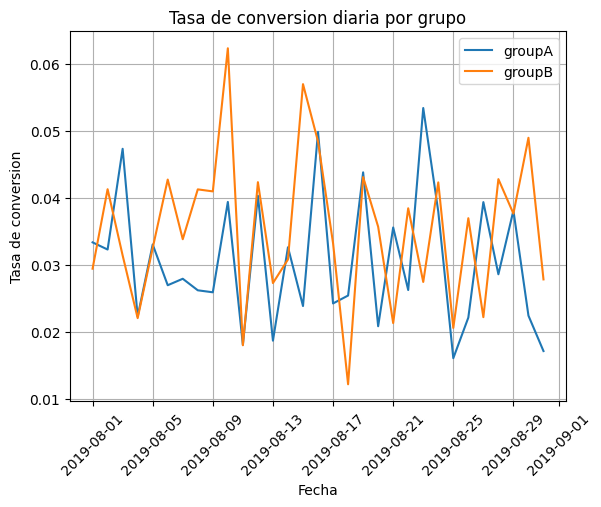

In [18]:
# Calcula el numero de pedidos por dia y por grupo 
daily_orders = orders.groupby(['date','group']).size().reset_index(name='orders')

#Combinar con los datos de visitas
convercion_data = pd.merge(visits,daily_orders, on= ['date','group'], how='left').fillna(0)

#Calculamos la tasa de conversion
convercion_data ['conversion_rate'] = convercion_data['orders'] / convercion_data['visits']

#Graficamos la tasa de conversion diaria por grupos

plt.Figure (figsize=(12,6))
for group in convercion_data['group'].unique():
    subset = convercion_data[convercion_data['group']== group]
    plt.plot (subset['date'], subset['conversion_rate'], label = f'group{group}')

plt.xlabel ('Fecha')
plt.ylabel ('Tasa de conversion')
plt.title ('Tasa de conversion diaria por grupo')
plt.legend()
plt.grid (True)
plt.xticks(rotation=45)
plt.show

- La tasa de conversión muestra mucha variabilidad y picos en ciertos días.
Puede deberse a eventos específicos, promociones o anomalías en los datos (como compras masivas por parte de unos pocos usuarios).
Tendriamos que analizae la tendencia general esto ayudaría a determinar si se trata de una fluctuación normal o de un patrón significativo.

### Traza un gráfico de dispersión del número de pedidos por usuario.

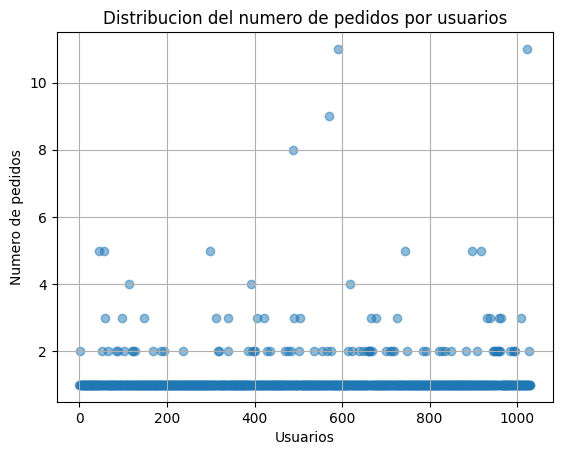

In [19]:
# Contar el numero de pedidos por usuario 
orders_per_user = orders.groupby('visitorid')['transactionid'].count().reset_index(name='num_orders')

#Graficamos el numero de pedidos por usuario

plt.Figure(figsize=(12,6))
plt.scatter(range(len(orders_per_user)),orders_per_user['num_orders'], alpha=0.5)
plt.xlabel ('Usuarios')
plt.ylabel ('Numero de pedidos')
plt.title  ('Distribucion del numero de pedidos por usuarios')
plt.grid (True)
plt.show()

- la mayoría de los usuarios tienen 1 o 2 pedidos y solo unos pocos tienen más de 3, esto podría sugerir que la mayoría de los usuarios son de bajo compromiso, mientras que unos pocos son altamente comprometidos.

- Hay outliers con un número alto de pedidos, podría ser útil investigar si estos son usuarios reales o si hay algún error en los datos.

### Calcula los percentiles 95 y 99 del número de pedidos por usuario. Define el punto en el cual un punto de datos se convierte en una anomalía.


In [20]:
percentile_95 = orders_per_user['num_orders'].quantile(0.95)
percentile_99 = orders_per_user['num_orders'].quantile(0.99)


print(f"Percentil 95: {percentile_95}")
print(f"Percentil 99: {percentile_99}")

anomaly_threshold = percentile_99
print(f"Un punto de datos se considera una anomalía si el número de pedidos es mayor que: {anomaly_threshold}")

Percentil 95: 2.0
Percentil 99: 4.0
Un punto de datos se considera una anomalía si el número de pedidos es mayor que: 4.0


### Traza un gráfico de dispersión de los precios de los pedidos.


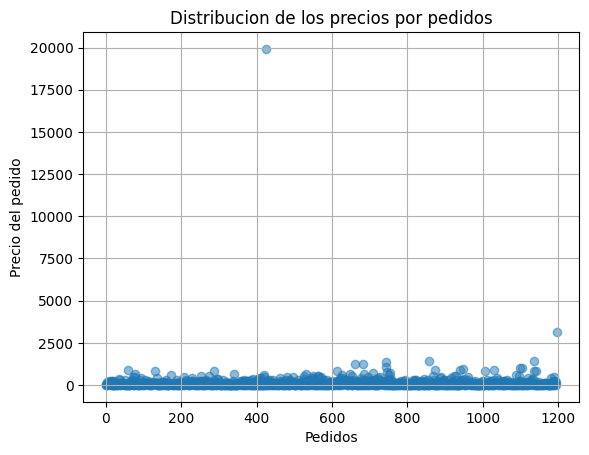

In [21]:
#Extraemos los precios 
price = orders['revenue']

#Graficamos los precios de los pedidos
plt.Figure(figsize=(12,6))
plt.scatter(range(len(price)),price, alpha=0.5)
plt.xlabel('Pedidos')
plt.ylabel ('Precio del pedido')
plt.title ('Distribucion de los precios por pedidos')
plt.grid (True)
plt.show()

- la mayoría de los puntos se concentran en un rango estrecho de precios, esto podría indicar que la mayoría de los productos o servicios tienen precios similares.

In [22]:
percentile_95 = price.quantile(0.95)
percentile_99 = price.quantile(0.99)

print(f"Percentil 95: {percentile_95}")
print(f"Percentil 99: {percentile_99}")

anomaly_threshold = percentile_99
print(f"Un punto de datos se considera una anomalía si el número de pedidos es mayor que: {anomaly_threshold}")

Percentil 95: 435.54
Percentil 99: 900.9039999999999
Un punto de datos se considera una anomalía si el número de pedidos es mayor que: 900.9039999999999


### Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto

In [23]:
# Calcular el número de pedidos por día y grupo
orders_per_day = orders.groupby(['date', 'group']).size().unstack(fill_value=0)

# Unir los datos de visitas y pedidos
conversion_data = visits.set_index(['date', 'group']).unstack()
conversion_data['orders_A'] = orders_per_day['A']
conversion_data['orders_B'] = orders_per_day['B']
conversion_data = conversion_data.reset_index()

# Calcular las tasas de conversión diarias
conversion_data['conversion_rate_A'] = conversion_data['orders_A'] / conversion_data[('visits', 'A')]
conversion_data['conversion_rate_B'] = conversion_data['orders_B'] / conversion_data[('visits', 'B')]

# Extraer las tasas de conversión diarias para cada grupo
conversion_rates_A = conversion_data['conversion_rate_A'].dropna()
conversion_rates_B = conversion_data['conversion_rate_B'].dropna()

## Realizar la prueba de Mann-Whitney U
stat, p_value = mannwhitneyu(conversion_rates_A, conversion_rates_B, alternative='two-sided')

print(f"Estadístico U: {stat:.4f}")
print(f"P-valor: {p_value:.4f}")

Estadístico U: 358.0000
P-valor: 0.0859


- No hay evidencia estadística suficiente para rechazar la hipótesis nula:

- El p-valor es 0.0859, que es mayor que el nivel de significancia comúnmente utilizado (0.05).

- Esto significa que no podemos concluir que haya una diferencia significativa en las tasas de conversión entre los grupos A y B.

- En otras palabras, las diferencias observadas en las tasas de conversión podrían deberse al azar y no a las variaciones aplicadas en la prueba A/B.

### Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto.

In [24]:
# Extraer los tamaños de pedido (revenue) para cada grupo
revenue_A = orders[orders['group'] == 'A']['revenue']
revenue_B = orders[orders['group'] == 'B']['revenue']

# Prueba de normalidad para el Grupo A
stat_A, p_value_A = shapiro(revenue_A)
print(f"Prueba de normalidad para el Grupo A: Estadístico = {stat_A:.4f}, p-valor = {p_value_A:.4f}")

# Prueba de normalidad para el Grupo B
stat_B, p_value_B = shapiro(revenue_B)
print(f"Prueba de normalidad para el Grupo B: Estadístico = {stat_B:.4f}, p-valor = {p_value_B:.4f}")

Prueba de normalidad para el Grupo A: Estadístico = 0.5799, p-valor = 0.0000
Prueba de normalidad para el Grupo B: Estadístico = 0.0856, p-valor = 0.0000


In [25]:
stat_levene, p_value_levene = levene(revenue_A, revenue_B)
print(f"Prueba de Levene: Estadístico = {stat_levene:.4f}, p-valor = {p_value_levene:.4f}")

stat_ttest, p_value_ttest = ttest_ind(revenue_A, revenue_B)
print(f"Prueba t de Student: Estadístico = {stat_ttest:.4f}, p-valor = {p_value_ttest:.4f}")

Prueba de Levene: Estadístico = 0.6488, p-valor = 0.4207
Prueba t de Student: Estadístico = -0.8346, p-valor = 0.4041


- No hay evidencia estadística suficiente para rechazar la hipótesis nula:

- El p-valor es 0.4041, que es mayor que el nivel de significancia comúnmente utilizado (0.05).

- Esto significa que no podemos concluir que haya una diferencia significativa en el tamaño promedio de pedido entre los grupos A y B.

- En otras palabras, las diferencias observadas en el tamaño promedio de pedido podrían deberse al azar y no a las variaciones aplicadas en la prueba A/B.

### Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados.

In [26]:
# Filtrar usuarios con más de 5 pedidos
orders_per_user = orders.groupby('visitorid').size().reset_index(name='num_orders')
normal_users = orders_per_user[orders_per_user['num_orders'] <= 5]['visitorid']
filtered_orders = orders[orders['visitorid'].isin(normal_users)]

# Filtrar pedidos con precios extremadamente altos (mayores que el percentil 99)
price_threshold = filtered_orders['revenue'].quantile(0.95)
filtered_orders = filtered_orders[filtered_orders['revenue'] <= price_threshold]

# Calcular el número total de pedidos por grupo después de filtrar
orders_per_group_filtered = filtered_orders.groupby('group').size()
print("Número de pedidos por grupo (filtrados):")
print(orders_per_group_filtered)

# Calcular el número total de visitas por grupo
visits_per_group = visits.groupby('group')['visits'].sum()
print("\nNúmero de visitas por grupo:")
print(visits_per_group)

# Calcular las tasas de conversión filtradas
conversion_rate_A_filtered = orders_per_group_filtered['A'] / visits_per_group['A']
conversion_rate_B_filtered = orders_per_group_filtered['B'] / visits_per_group['B']

print(f"\nTasa de conversión del Grupo A (filtrada): {conversion_rate_A_filtered:.4f}")
print(f"Tasa de conversión del Grupo B (filtrada): {conversion_rate_B_filtered:.4f}")

# Datos para la prueba
num_pedidos_A_filtered = orders_per_group_filtered['A']
num_pedidos_B_filtered = orders_per_group_filtered['B']
num_visitas_A = visits_per_group['A']
num_visitas_B = visits_per_group['B']

# Realizar la prueba de proporciones
count = [num_pedidos_A_filtered, num_pedidos_B_filtered]  # Número de éxitos (pedidos)
nobs = [num_visitas_A, num_visitas_B]   # Número de intentos (visitas)
stat, p_value = proportions_ztest(count, nobs)

print(f"\nEstadístico Z: {stat:.4f}")
print(f"P-valor: {p_value:.4f}")

Número de pedidos por grupo (filtrados):
group
A    511
B    589
dtype: int64

Número de visitas por grupo:
group
A    18736
B    18916
Name: visits, dtype: int64

Tasa de conversión del Grupo A (filtrada): 0.0273
Tasa de conversión del Grupo B (filtrada): 0.0311

Estadístico Z: -2.2260
P-valor: 0.0260


- Evidencia estadística para rechazar la hipótesis nula:

- El p-valor es 0.0260, que es menor que el nivel de significancia comúnmente utilizado (0.05).

- Esto significa que rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en las tasas de conversión entre los grupos A y B.

- En otras palabras, las diferencias observadas en las tasas de conversión no se deben al azar, sino que están relacionadas con las variaciones aplicadas en la prueba A/B.

### Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados. 

In [27]:
# Filtrar usuarios con más de 5 pedidos
orders_per_user = orders.groupby('visitorid').size().reset_index(name='num_orders')
normal_users = orders_per_user[orders_per_user['num_orders'] <= 5]['visitorid']
filtered_orders = orders[orders['visitorid'].isin(normal_users)]

# Filtrar pedidos con precios extremadamente altos (mayores que el percentil 99)
price_threshold = filtered_orders['revenue'].quantile(0.99)
filtered_orders = filtered_orders[filtered_orders['revenue'] <= price_threshold]


# Extraer los tamaños de pedido (revenue) para cada grupo después de filtrar
revenue_A_filtered = filtered_orders[filtered_orders['group'] == 'A']['revenue']
revenue_B_filtered = filtered_orders[filtered_orders['group'] == 'B']['revenue']

# Prueba de normalidad para el Grupo A
stat_A, p_value_A = shapiro(revenue_A_filtered)
print(f"Prueba de normalidad para el Grupo A: Estadístico = {stat_A:.4f}, p-valor = {p_value_A:.4f}")

# Prueba de normalidad para el Grupo B
stat_B, p_value_B = shapiro(revenue_B_filtered)
print(f"Prueba de normalidad para el Grupo B: Estadístico = {stat_B:.4f}, p-valor = {p_value_B:.4f}")

# Prueba de Levene para homogeneidad de varianzas
stat_levene, p_value_levene = levene(revenue_A_filtered, revenue_B_filtered)
print(f"Prueba de Levene: Estadístico = {stat_levene:.4f}, p-valor = {p_value_levene:.4f}")


# Prueba de Mann-Whitney U
stat_mw, p_value_mw = mannwhitneyu(revenue_A_filtered, revenue_B_filtered, alternative='two-sided')
print(f"Prueba de Mann-Whitney U: Estadístico U = {stat_mw:.4f}, p-valor = {p_value_mw:.4f}")

Prueba de normalidad para el Grupo A: Estadístico = 0.6768, p-valor = 0.0000
Prueba de normalidad para el Grupo B: Estadístico = 0.6961, p-valor = 0.0000
Prueba de Levene: Estadístico = 0.0412, p-valor = 0.8392
Prueba de Mann-Whitney U: Estadístico U = 162081.5000, p-valor = 0.8418


- No hay evidencia estadística suficiente para rechazar la hipótesis nula:

- El p-valor es 0.8418, que es mucho mayor que el nivel de significancia comúnmente utilizado (0.05).

- Esto significa que no podemos concluir que haya una diferencia significativa en el tamaño promedio de pedido entre los grupos A y B.

- En otras palabras, las diferencias observadas en el tamaño promedio de pedido podrían deberse al azar y no a las variaciones aplicadas en la prueba A/B.

# Decisión: Parar la prueba, concluir que no hay diferencia entre los grupos.